<a href="https://colab.research.google.com/github/Zorug/Steam-Stuff/blob/master/BS_%26_CSV_compare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Info

comparação com os dados do site: https://www.steamcardexchange.net 

extração do csv: https://steam.tools/cards/

In [0]:
""" info da columns:
Game: Name of the set's game
# Cards: Number of cards in the set
Set Price: The total price of all the cards for the set
Card Avg: The averege price of a card in the set
Booster Avg: The average price of a card from the set's booster
Booster %: How many percent cheaper avarage booster cards are for the set
Emote Avg: The average price of the set's emoticons
BG Avg: The average price of the set's bachgrounds
Avg Qty: The average quantity of items on the market
Discount: The money you would make by selling all your drops for that game
Added: The date the set was added
"""

" info da columns:\nGame: Name of the set's game\n# Cards: Number of cards in the set\nSet Price: The total price of all the cards for the set\nCard Avg: The averege price of a card in the set\nBooster Avg: The average price of a card from the set's booster\nBooster %: How many percent cheaper avarage booster cards are for the set\nEmote Avg: The average price of the set's emoticons\nBG Avg: The average price of the set's bachgrounds\nAvg Qty: The average quantity of items on the market\nDiscount: The money you would make by selling all your drops for that game\nAdded: The date the set was added\n"

# Importanto libs e dados

In [0]:
import pandas as pd

#csv_source = 'STC_set_data.csv'
csv_source = 'https://raw.githubusercontent.com/Zorug/Steam-Stuff/master/STC_set_data.csv'
dados_csv = pd.read_csv(csv_source)
qnt_dados = dados_csv.shape[0]
qnt_dados

9156

In [0]:
dados_csv.sample(2)

,Game,# Owned,# Unique,# Cards,Badge Lvl,Set Price,Price Diff,Card Avg,Booster Avg,Booster %,Emote Avg,BG Avg,Avg Qty,Discount,Added,AppId
7084,Replay - VHS is not dead,0,0,10,0,0.48,0.48,0.05,0.03,40.0,0.06,0.07,71,0.22,2015-07-07,333490
1162,Vantage: Primitive Survival Game,0,0,10,0,1.30,1.30,0.13,NaN,0.0,0.00,1.16,11,0.57,2018-04-30,342910


#Organizando DataSet

## Limpeza das colunas

In [0]:
dados_csv = dados_csv.drop(['# Owned', '# Unique', 'Badge Lvl','Emote Avg', 'BG Avg', 'Discount', 'Added'], axis = 1)

In [0]:
dados_csv.sample(2)

,Game,# Cards,Set Price,Price Diff,Card Avg,Booster Avg,Booster %,Avg Qty,AppId
319,Skyland: Heart of the Mountain,5,1.07,1.07,0.21,NaN,0.0,33,949800
8578,FaeVerse Alchemy,12,0.59,0.59,0.05,0.03,40.0,176,282880


##Formatação dos tipos

In [0]:
dados_csv.dtypes

Game            object
# Cards          int64
Set Price       object
Price Diff      object
Card Avg       float64
Booster Avg    float64
Booster %       object
Avg Qty          int64
AppId            int64
dtype: object

In [0]:
def remove_virgula_perdida(sentenca): # aqui estamos esvitando um erro de conversão
    sentenca = sentenca.replace(',','')
    return sentenca

In [0]:
para_float = ['Set Price', 'Price Diff', 'Booster %']
for coluna in dados_csv[para_float]:
    dados_csv[coluna] = dados_csv[coluna].apply(remove_virgula_perdida)

dados_csv[para_float] = dados_csv[para_float].astype('float64')
dados_csv['AppId'] = dados_csv['AppId'].astype('str')

dados_csv.dtypes

Game            object
# Cards          int64
Set Price      float64
Price Diff     float64
Card Avg       float64
Booster Avg    float64
Booster %      float64
Avg Qty          int64
AppId           object
dtype: object

#Me parece que o price Diff é o mesmovalor do set price, será?

In [0]:
teste = dados_csv[['Set Price', 'Price Diff']]
teste['Diferença'] = teste['Set Price'] - teste['Price Diff']
teste.query('Diferença != 0.0')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Set Price,Price Diff,Diferença


se não há diferença então são iguais

In [0]:
dados_csv = dados_csv.drop('Price Diff', axis=1)

# BeautifulSoup

In [0]:
import bs4
from urllib.request import urlopen
from bs4 import BeautifulSoup

In [0]:
def arruma_string(string_to_go):
  if(string_to_go == 'A'): return 'nan'
  elif(string_to_go[0] == 'n'): return string_to_go[4:]
  else: return string_to_go

def captura_dados_cartas(soup):
  cards_script = soup.find("div",{"id":"cards"})
  card_list = cards_script.findAll("div",{"class":"showcase-element"})
  temporario = []
  for item in card_list: # retira itens vazios
    if not item.a == None: temporario.append(item)
  card_list = temporario

  precos_das_cartas = []
  for item in card_list: 
    try: 
      precos_das_cartas.append( arruma_string( ((item.find("div", {"class":"element-button"})).text)[8:] ) )
    except:
      print('Arumando erro 368020, sem valor para carta... adicinonando NaN')
      precos_das_cartas.append( 'nan' )

  precos_das_cartas = pd.Series(precos_das_cartas).apply(remove_virgula_perdida).astype('float64')

  return precos_das_cartas

In [0]:
def captura_dados_booster(soup):
  booster_script = soup.find("div",{"id":"booster"})

  try:
    sub_script = (booster_script.find("div",{"class":"showcase-element-container booster"}))
    booster_title = sub_script.img["alt"]
    preco_booster = arruma_string( ((sub_script.find("a", {"class":"button-blue"})).text)[8:] )
  except:
    #print('Erro de booster inexistente.')
    booster_title = '------'
    preco_booster = 'nan'

  preco_booster = pd.Series(preco_booster).apply(remove_virgula_perdida).astype('float64').values[0]
  
  return booster_title, preco_booster

In [0]:
def arredonda(valor, casas = 2):
  return round(valor, casas)

In [0]:
list_index_sample = []
list_booster_title = []
list_booster_price = []
list_set_price = []
list_card_mean = []

for i in range(150):
#for i in range(qnt_dados):
  amostra = dados_csv.sample(1)
  #amostra = dados_csv[dados_csv.index == i]
  AppId = amostra['AppId'].values[0]
  url = 'https://www.steamcardexchange.net/index.php?gamepage-appid-'+AppId

  uClient = urlopen(url)
  page_html = uClient.read()
  uClient.close()

  soup = BeautifulSoup(page_html, 'html.parser')

  precos_das_cartas = captura_dados_cartas(soup)
  booster_title, preco_booster = captura_dados_booster(soup)

  list_index_sample.append(amostra['AppId'].index[0])
  list_set_price.append(arredonda(precos_das_cartas.sum()))

  list_card_mean.append(arredonda(precos_das_cartas.mean()))
  list_booster_title.append(booster_title)
  list_booster_price.append(preco_booster)

# Comparações

In [0]:
dados_to_compare = dados_csv.loc[list_index_sample]
compare_csv = dados_to_compare.drop(['Game', '# Cards', 'Avg Qty', 'AppId'], axis=1)
compare_csv.sample(3)

,Set Price,Card Avg,Booster Avg,Booster %
6028,0.39,0.07,0.05,28.6
8141,0.38,0.06,0.04,33.3
981,0.98,0.12,0.24,-100.0


In [0]:
compare_csv['BS4_Set'] = list_set_price
compare_csv['BS4_CAvg'] = list_card_mean
compare_csv['BS4_Booster'] = list_booster_price

compare_csv.sample(3)

,Set Price,Card Avg,Booster Avg,Booster %,BS4_Set,BS4_CAvg,BS4_Booster
2429,17.78,1.48,NaN,0.0,16.26,1.35,NaN
7457,0.86,0.11,0.38,-245.5,0.98,0.12,1.15
263,0.62,0.09,0.12,-33.3,0.62,0.09,0.30


In [0]:
compare_csv.corr().round(2)

,Set Price,Card Avg,Booster Avg,Booster %,BS4_Set,BS4_CAvg,BS4_Booster
Set Price,1.00,0.96,0.22,0.01,0.97,0.83,0.29
Card Avg,0.96,1.00,0.24,0.01,0.96,0.90,0.29
Booster Avg,0.22,0.24,1.00,-0.96,0.27,0.26,0.98
Booster %,0.01,0.01,-0.96,1.00,-0.00,-0.00,-0.81
BS4_Set,0.97,0.96,0.27,-0.00,1.00,0.92,0.30
BS4_CAvg,0.83,0.90,0.26,-0.00,0.92,1.00,0.25
BS4_Booster,0.29,0.29,0.98,-0.81,0.30,0.25,1.00


In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

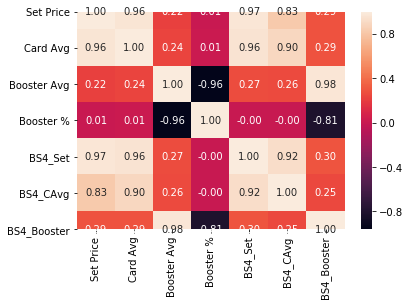

In [0]:
matriz_correlacao = compare_csv.corr()
#plt.figure(figsize = (11, 10))
ax = sns.heatmap(matriz_correlacao, annot = True, fmt = ".2f")
ax

Text(0.5, 0.98, 'Relacionando os dados BS4xCSV')

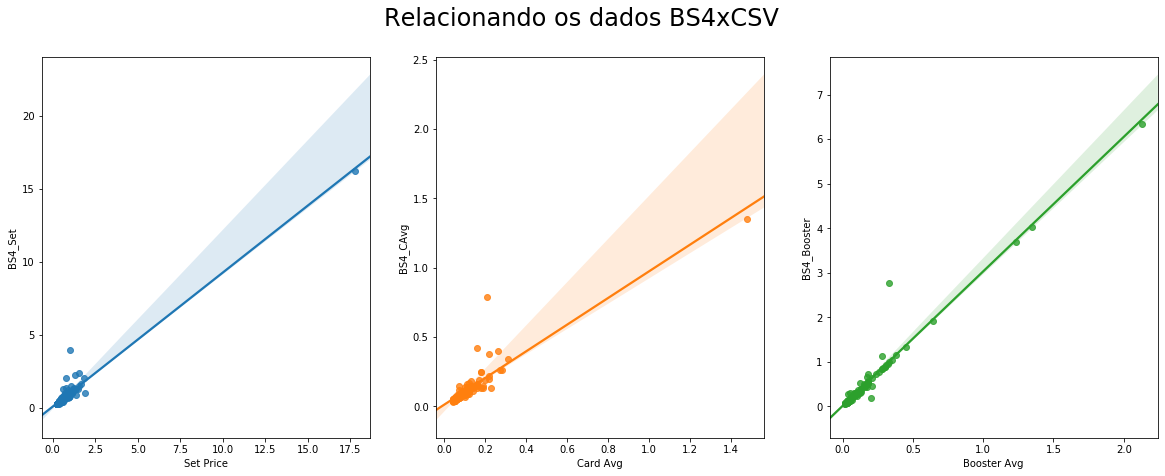

In [0]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=False, figsize=(20, 7))
sns.regplot(x='Set Price', y='BS4_Set', data=compare_csv, ax=ax1)
sns.regplot(x='Card Avg', y='BS4_CAvg', data=compare_csv, ax=ax2)
sns.regplot(x='Booster Avg', y='BS4_Booster', data=compare_csv, ax=ax3)
fig.suptitle("Relacionando os dados BS4xCSV", fontsize=24)

Text(0.5, 0.98, 'Comparando os dados BS4xCSV')

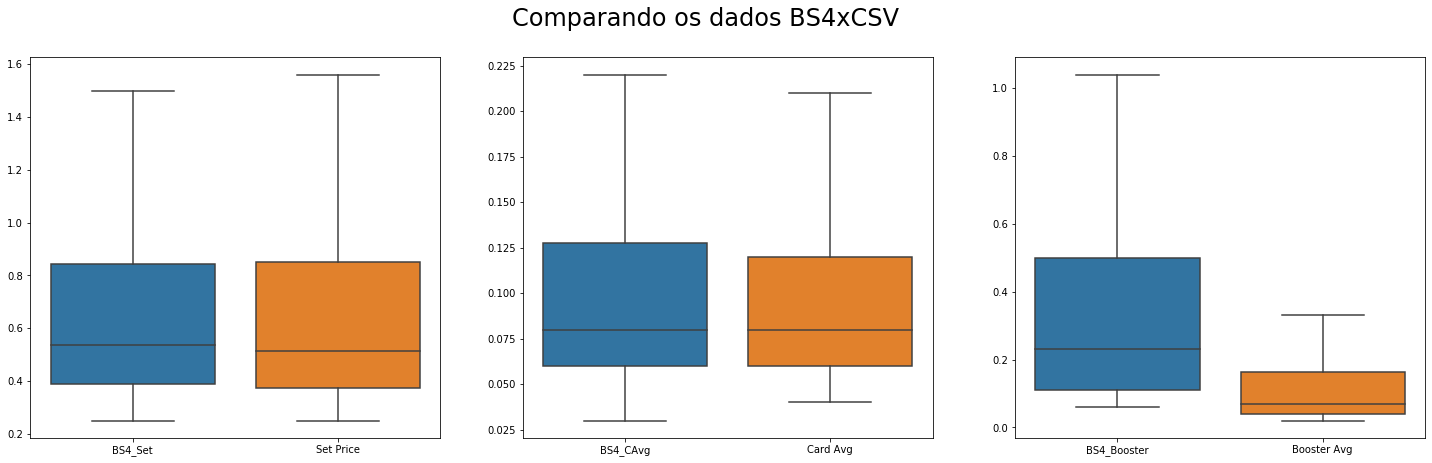

In [0]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=False, figsize=(25, 7))
sns.boxplot(data=compare_csv[['BS4_Set', 'Set Price']], showfliers=False, ax=ax1)
sns.boxplot(data=compare_csv[['BS4_CAvg', 'Card Avg']], showfliers=False, ax=ax2)
sns.boxplot(data=compare_csv[['BS4_Booster', 'Booster Avg']], showfliers=False, ax=ax3)
fig.suptitle("Comparando os dados BS4xCSV", fontsize=24)



---

## **Há uma diferença bem clara na comparação dos boosters**

---





## Estudo dos nulos

Text(0.5, 1.0, 'Comparando os dados BS4xCSV sem nulos')

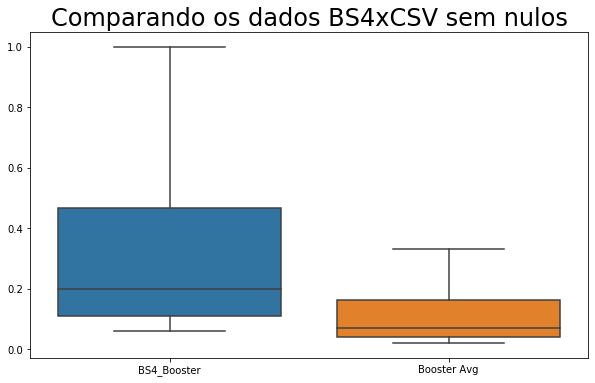

In [0]:
import numpy as np
not_null_1 = compare_csv[~compare_csv['Booster Avg'].isna()][["BS4_Booster", "Booster Avg"]]

compare_sem_nulos = not_null_1[~not_null_1['BS4_Booster'].isna()]

plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=compare_sem_nulos, showfliers=False)
ax.set_title("Comparando os dados BS4xCSV sem nulos", fontsize=24)
#ax.figsize = (25, 7)



---

## **Essa verificação não foi relevante... talvez haja uma diferença bastante significativa ai**

---





In [0]:
compare_sem_nulos["Differença Booster"] = compare_sem_nulos["BS4_Booster"] - compare_sem_nulos["Booster Avg"]

In [0]:
compare_sem_nulos.head()

,BS4_Booster,Booster Avg,Differença Booster
2011,0.11,0.04,0.07
3276,0.32,0.10,0.22
7002,0.39,0.13,0.26
7405,0.07,0.03,0.04
6331,0.10,0.03,0.07


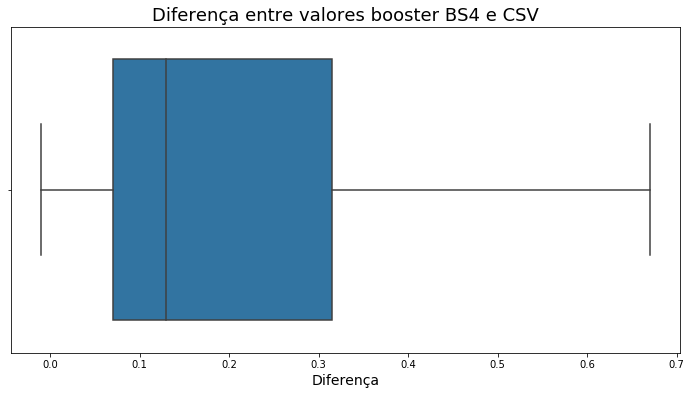

In [0]:
ax = sns.boxplot(compare_sem_nulos["Differença Booster"], showfliers=False)
ax.figure.set_size_inches(12, 6)
ax.set_title('Diferença entre valores booster BS4 e CSV', fontsize=18)
ax.set_xlabel('Diferença', fontsize=14)
ax

In [0]:
compare_sem_nulos["Differença Booster"].describe().round(2)

count    136.00
mean       0.29
std        0.52
min       -0.01
25%        0.07
50%        0.13
75%        0.32
max        4.20
Name: Differença Booster, dtype: float64